# Univariate LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dataclasses import dataclass
from typing import Union, Tuple, List

2022-11-10 13:33:16.975036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 13:33:19.152785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 13:33:19.152873: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-10 13:33:19.361117: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 13:33:23.250453: W tensorflow/stream_executor/platform/de

In [2]:
# Read the data.
df = pd.read_csv('smoothed_data_kansas.csv')

In [3]:
x = np.concatenate((df['x_19'], df['x_20'], df['x_22']), axis=0)
# NDVI time series.
y = np.concatenate((df['y_19'], df['y_20'], df['y_22']), axis=0)
# Generate the time vector in days after planting.
time = [i for i in range(len(y))]

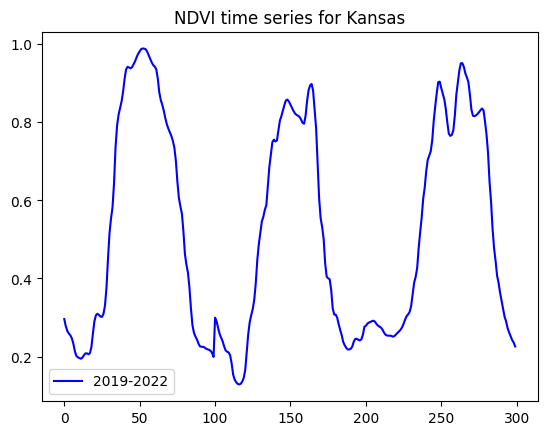

In [4]:
plt.title('NDVI time series for Kansas')
plt.plot(time, y, 'b', label='2019-2022')
plt.legend()
plt.show()

In [5]:
# Time series parameters.
@dataclass
class G:
  TIME, SERIES = time, y
  # Number of days to be used on the training set.
  SPLIT_TIME = 200
  # Data points to make our prediction.
  WINDOW_SIZE = 25
  # How many items will we supply per batch.
  BATCH_SIZE = 32
  # Define the Tensorflow sample buffer.
  SHUFFLE_BUFFER_SIZE = 1000
  # Number of epochs.
  EPOCHS = 50

In [ ]:
def train_val_split(
  time: Union[List, np.ndarray],
  series: Union[List, np.ndarray],
  time_step: int = G.SPLIT_TIME
) -> Tuple[np.ndarray, ...]:
  """
  Divide the time series into training and validation set.
  """
  assert isinstance(time, (np.ndarray, list))
  
  # Training time vector.
  time_train = time[:time_step]
  # NDVI series vector.
  series_train = series[:time_step]
  # Validation time vector.
  time_valid = time[time_step:]
  # NDVI series vector.
  series_valid = series[time_step:]
  
  return time_train, series_train, time_valid, series_valid

def windowed_dataset(
	series: Union[List, np.ndarray],
	window_size: int = G.WINDOW_SIZE,
	batch_size: int = G.BATCH_SIZE,
	shuffle_buffer: int = G.SHUFFLE_BUFFER_SIZE
) -> tf.data.Dataset:
	"""
	We create time windows to create X and y features.
	For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
	"""
	# Create a TensorFlow dataset from np.arrays or lists.
	dataset = tf.data.Dataset.from_tensor_slices(series)
	# Create a DataFrame of windows.
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	# Flat the vectors and make batches of the data.
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	# Randomly shuffle the data.
	dataset = dataset.shuffle(shuffle_buffer)
	# Transform the data to the format X, y.
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset

In [ ]:
# Split the data into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Create the dataset with time windows.
dataset = windowed_dataset(series_train)

In [ ]:
def create_uncompiled_model():
  """
  Function to define a sequential model.
  Appropriate for a plain stack of layers where 
  each layer has exactly ONE input tensor and ONE output tensor.
  """
  model = tf.keras.models.Sequential([
      # Lambda layer to handle the input data format. 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                              input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      # Layer of prediction.
      tf.keras.layers.Dense(1),
  ])

  return model

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.03):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [ ]:
def create_model():
  tf.random.set_seed(51)

  # Call the uncompiled class.
  model = create_uncompiled_model()
  
  # Compile model for training.
  model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"]
  )
  return model
  
model = create_model()

In [ ]:
# Training and assign the callback
history = model.fit(dataset, epochs=G.EPOCHS, callbacks=[early_stopping])

In [ ]:
def compute_metrics(true_series, forecast):
  """
  Helper to print MSE and MAE
  """
  mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
  mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

  return mse, mae

def model_forecast(model, series, window_size):
  """
  This function converts the input series into a dataset with time windows for forecasting
  """
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  
  return forecast

def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [ ]:

# Prediction on the whole series
all_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
mse, mae = compute_metrics(series_valid, val_forecast)
print(f"mse: {mse}, mae: {mae}")
new_forecast = []

new_forecast_series = G.SERIES[-G.WINDOW_SIZE:] 

pred = model.predict(new_forecast_series[np.newaxis])
plt.figure(figsize=(15, 6))
plt.plot(G.TIME[-100:], G.SERIES[-100:], label="last 100 points of time series")
plt.scatter(max(G.TIME)+1, pred, color="red", marker="x", s=70, label="prediction")
plt.legend()
plt.show()



In [ ]:
new_forecast = []

for i in range(100):
  new_forecast_series = G.SERIES[-G.WINDOW_SIZE:]  
  pred = model.predict(new_forecast_series[np.newaxis])
  new_forecast.append(pred.reshape(-1))
  G.SERIES = np.append(G.SERIES, pred)
new_time = [i for i in range(len(G.TIME) + 1, len(G.TIME) + 101)]
plt.figure(figsize=(15, 6))
plt.plot(G.TIME[:300], G.SERIES[:300], label="last 400 points of time series")
plt.plot(new_time, new_forecast, color="red", label="prediction")
plt.legend()
plt.show()